# 序列与编码器

## 机器翻译与数据集

In [2]:
import os
import torch
from d2l import torch as d2l 
import re
import matplotlib.pyplot as plt
import collections
from torch.utils import data

In [3]:
# 读取数据
"""
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
"""
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                          '94646ad1522d915e7b0f9296181140edcf86a4f5')
#@save
def read_data_nmt():
    """载⼊“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



set() 函数创建一个无序不重复元素集，可进行关系测试，删除重复数据，还可以计算交集、差集、并集等。

In [24]:
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    # 使用空格替代不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' '+ char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

"""
char 如果char是符号且char的前一个不是空格就加一个空格， 否则的化就直接加上字符
"""
text = preprocess_nmt(raw_text)
print(text[:96])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
fire !	au feu !


tokenize_nmt函数对前num_examples个⽂本序列对进⾏词元，其中每个词元要么是⼀个词，要么是⼀个标点符号。此函数返回两个词元列表： source和target： source[i]是源语⾔（这⾥是英语）第i个⽂本序列的词元列表， target[i]是⽬标语⾔（这⾥是法语）第i个⽂本序列的词元列表。

In [25]:
# 词元化
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break           # 控制 num_examplioes>0 且找的词元小于num_examples
        parts = line.split('\t')  # 由于在两个文本间有个\t
        if len(parts) == 2:  
            source.append(parts[0].split(' '))  # 将符号和字符分开
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
print(source[:7]) 
print(target[:7])

[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!'], ['fire', '!']]
[['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!'], ['au', 'feu', '!']]


plt（matplotlib.pyplot）使用rc配置文件来自定义图形的各种默认属性，称之为rc配置或rc参数。

通过rc参数可以修改默认的属性，包括窗体大小、每英寸的点数、线条宽度、颜色、样式、坐标轴、坐标和网络属性、文本、字体等。rc参数存储在字典变量中，通过字典的方式进行访问。

plt.rcParams[’figure.figsize’] 图像显示大小

blog地址：https://blog.csdn.net/qq_51143009/article/details/110388021

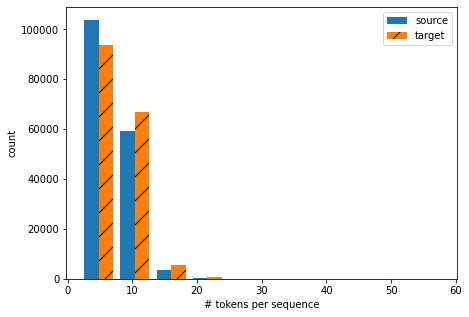

In [10]:
# 绘制词元数量的直方图 每个⽂本序列所包含的词元数量的直⽅图  一个文本序列有多个单词
def show_list_len_pair_hist(legend,xlabel, ylabel, xlist, ylist):
    plt.rcParams['figure.figsize'] = (7, 5)
    _,_,patches = plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:      # 设置图例
        patch.set_hatch('/')
    plt.legend(legend)
    
show_list_len_pair_hist(['source', 'target'],'# tokens per sequence',
                        'count', source, target);

In [26]:
# 词表
src_vocab = d2l.Vocab(source, min_freq = 2, reserved_tokens = ['<pad>', '<bos>', '<eos>'])
len(src_vocab)   # 返回一个Vocab类， 统计唯一词元的数量

10012

In [27]:
# 加载数据集
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps] # 截断
    return line + [padding_token] * (num_steps - len(line)) # 填充 将剩下的元素进行填充
print(source[0])
truncate_pad(src_vocab[source[0]],10,src_vocab['<pad>'])  # src_vocab[source[i]] 返回对应元素的下标

['go', '.']


[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [31]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]   # 将lines中的文本string变成了下标，对于每一句话的结尾都加上<eos>
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines ])    # 转换成时间步
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)  # 记录了每个⽂本序列的⻓度，统计⻓度时排除了填充词元
    return array, valid_len

In [40]:
# 数据迭代器
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())   # 返回文本
    source, target = tokenize_nmt(text, num_examples)  # 词元化
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>','<bos>', '<eos>'])   # 生成下标、词元对应字典
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>','<bos>','<eos>'])    # 生成下标、词元对应字典
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len) # 将时间步输入/文本序列长度传进去
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab,tgt_vocab

In [32]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print("X:", X.type(torch.int32))
    print("X的有效长度:", X_valid_len)
    print('Y:', Y.type(torch.int32))
    print("Y的有效长度:", Y_valid_len)
    break

X: tensor([[  9,  28,   4,   3,   1,   1,   1,   1],
        [118,  55,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[73,  0,  4,  3,  1,  1,  1,  1],
        [ 0,  4,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([4, 3])


## 编码器-解码器架构

In [41]:
#编码器
# 这个方法没有被子类重写，但是调用了，就会报错
# 指定⻓度可变的序列作为编码器的输⼊X。任何继承这个Encoder 基类的模型将完成代码实现。
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError

In [42]:
# 解码器
"""
新增⼀个init_state函数，⽤于将编码器的输出（enc_outputs）转换为编码后的状态。
此步骤可能需要额外的输⼊，如：输⼊序列的有效⻓度.
为了逐个地⽣成⻓度可变的词元序列，
解码器在每个时间步都会将输⼊（例如：在前⼀时间步⽣成的词元）和编码后的状态映射成当前时间步的输出词元。
"""
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
    def init_state(self, enc_output, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

In [43]:
"""
编码器-解码器”架构包含了⼀个编码器和⼀个解码器，并且还拥有可选的额外的参数。
在前向传播中，编码器的输出⽤于⽣成编码状态，这个状态⼜被解码器作为其输⼊的⼀部分。
"""
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的积累"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 序列到序列学习（seq2seq）

In [1]:
import collections
import math 
import torch
from torch import nn
from d2l import torch as d2l

Sparse layers
```python
class torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2, scale_grad_by_freq=False, sparse=False)
```

一个保存了固定字典和大小的简单查找表。这个模块常用来保存词嵌入和用下标检索它们。模块的输入是一个下标的列表，输出是对应的词嵌入。

参数：

num_embeddings (int) - 嵌入字典的大小

embedding_dim (int) - 每个嵌入向量的大小

padding_idx (int, optional) - 如果提供的话，输出遇到此下标时用零填充

max_norm (float, optional) - 如果提供的话，会重新归一化词嵌入，使它们的范数小于提供的值

norm_type (float, optional) - 对于max_norm选项计算p范数时的p

scale_grad_by_freq (boolean, optional) - 如果提供的话，会根据字典中单词频率缩放梯度

变量：

weight (Tensor) -形状为(num_embeddings, embedding_dim)的模块中可学习的权值

形状：

输入： LongTensor (N, W), N = mini-batch, W = 每个mini-batch中提取的下标数

输出： (N, W, embedding_dim)

In [20]:
# 编码器子类
# 嵌⼊层的权重是⼀个矩阵，其⾏数等于输⼊词表的⼤⼩（vocab_size），其列数等于特征向量的维度（embed_size）
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
        
    def forward(self, X, *args):
        # 输出'X'的形状:（batch_size,num_steps,embed_size）
        X = self.embedding(X)    
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)      # permute(dims)将坐标轴转换
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状为:(num_steps,batch_size,num_hiddens)
        # state[0]的形状：（num_layers,batch_size,num_hiddens）
        return output, state

In [21]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4,7), dtype =torch.long)
output, state = encoder(X)
output.shape,state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [22]:
# 解码器子类
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        # 输出'X'的形状：（batch_size,num_steps, embed_size）
        X = self.embedding(X).permute(1,0,2)
        # 广播context,使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)   # embed_size 合并
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1,0,2)
        # output的形状：(batch_size,num_steps,vocab_size)
        # state[0]的形状：(num_layers,batch_size,num_hiddens)
        return output, state

In [23]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))   # 将隐藏状态返回
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [24]:
# 损失函数
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype = torch.float32,
                        device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

In [25]:
X =torch.tensor([[1,2,3],[4,5,6]])
print(sequence_mask(X, torch.tensor([1,2])))
X = torch.ones(2, 3, 4)
print(sequence_mask(X, torch.tensor([1, 2]), value=-1))

tensor([[1, 0, 0],
        [4, 5, 0]])
tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])


In [26]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状： (batch_size,num_steps,vocab_size)
    # label的形状： (batch_size,num_steps)
    # valid_len的形状： (batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0,2,1),label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [27]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [28]:
# 训练
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel = 'loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                           device=device).reshape(-1,1)
            dec_input = torch.cat([bos, Y[:,:-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len) 
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()              # 损失函数的标量进行反向传播
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.020, 9614.3 tokens/sec on cpu


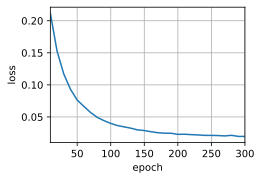

In [31]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [34]:
# 预测
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] +[
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens,dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']],dtype=torch.long, device=device),dim=0)
    output_seq, attention_weight_seq =[], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)),attention_weight_seq

BLEU：
$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$

其中lenlabel表⽰标签序列中的词元数和 lenpred表⽰预测序列中的词元数， k是⽤于匹配的最⻓的n元语法。另
外，⽤pn表⽰n元语法的精确度，它是两个数量的⽐值：第⼀个是预测序列与标签序列中匹配的n元语法的数
量，第⼆个是预测序列中n元语法的数量的⽐率。

In [35]:
# 预测
def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0,1 - len_label / len_pred))
    for n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [36]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis chez moi suis entrez !, bleu 0.636
